In [3]:
from keras.layers import *
from keras.models import Model, load_model
from keras.datasets import fashion_mnist
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras import optimizers
from keras import backend as K
import scipy
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import pandas as pd
import numpy as np

In [4]:
# Load data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [5]:
# x_train = pd.read_csv('../input/fashion-mnist_train.csv')
# x_test = pd.read_csv('../input/fashion-mnist_test.csv')

# y_train = x_train.pop('label')
# y_test = x_test.pop('label')

x_train = np.array(x_train).reshape(-1, 28, 28) / 255.0
x_test = np.array(x_test).reshape(-1, 28, 28) / 255.0

In [6]:
x_train.shape

(60000, 28, 28)

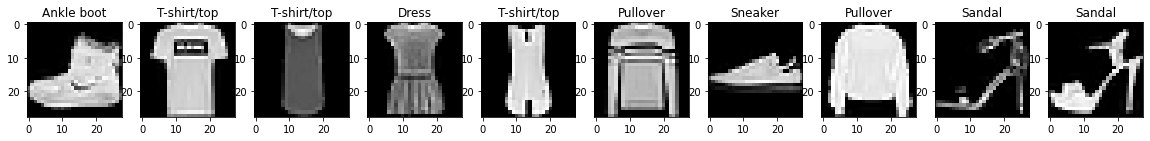

In [7]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(x_train[i], cmap='gray')
    ax[i].set_title(labeldict[y_train[i]])

Now we can get to building the autoencoder. I decided to give it only two latent variables, so that we can compare this approach to other dimensionality reduction techniques by visualizing the images on a plane.

In [8]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

def make_and_fit():
    inputs = Input(shape=(28, 28, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(2, activation='relu')(x)

    encoder = Model(inputs=inputs, outputs=encoded)
    
    encoded_inputs = Input(shape=(2,))

    x = Dense(4, activation='relu')(encoded_inputs)
    x = Reshape((2, 2, 1))(x)
    x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((7, 7))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(inputs=encoded_inputs, outputs=decoded)
    
    x = encoder(inputs)
    x = decoder(x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'mse'])

    print(model.summary())
    
    clr = ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=3,
        min_delta=0.01,
        cooldown=0,
        min_lr=1e-7,
        verbose=1)

    model.fit(
        x_train,
        x_train,
        batch_size=256,
        epochs=50,
        shuffle=True,
        validation_data=(x_test, x_test),
        callbacks=[clr])

    return model, encoder, decoder

model, encoder, decoder = make_and_fit()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 2)                 34889     
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         42417     
Total params: 77,306
Trainable params: 77,082
Non-trainable params: 224
_________________________________________________________________
None


Now that the network is trained, let's visualize the results. Here are two sets of images that the model encodes then decodes. The first is taken out of the test set, the second is random noise.

Between the two images is displayed the encoded representation of the input images (two variables).

In [ ]:
def get_triple(inputs):
    latent_repr = encoder.predict(inputs)
    outputs = decoder.predict(latent_repr)
    latent_repr = latent_repr.reshape((latent_repr.shape[0], latent_repr.shape[1], 1))

    return inputs, latent_repr, outputs

def show_encodings(inputs, latent_repr, outputs):
    n = len(inputs)
    fig, axes = plt.subplots(2, n, figsize=(2*n, 5))
    for i in range(n):
        axes[1, i].set_title('({0:.2f}, {1:.2f})'.format(float(latent_repr[i, 0]), float(latent_repr[i, 1])))
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
show_encodings(*get_triple(x_test[:10]))
inputs = np.random.random(size=(10, 4, 4, 1))
inputs = scipy.ndimage.zoom(inputs, (1, 7, 7, 1))
show_encodings(*get_triple(inputs))

Now, let's compare this approach to other common dimensionality reduction techniques: PCA and T-SNE. We will do this by reducing the 784-dimensional space of the images to two using a technique we want to test. Then we will plot the distribution of the ten classes in the new two-dimensional space and see how separated they are.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_latent(mode, count, technique):
    idx = np.random.choice(len(x_test), count)
    inputs = x_test[idx]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(technique)
    if technique == 'autoencoder':
        coords = encoder.predict(inputs)
    elif technique == 'pca':
        coords = PCA(n_components=2).fit_transform(inputs.reshape(count, -1))
    elif technique == 'tsne':
        coords = TSNE(n_components=2).fit_transform(inputs.reshape(count, -1))

    if mode == 'imgs':
        for image, (x, y) in zip(inputs, coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = y_test[idx]
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{} ({})'.format(labeldict[i], i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

plot_latent('dots', 10000, 'autoencoder')
plot_latent('dots', 10000, 'pca')
plot_latent('dots', 2000, 'tsne')

plot_latent('imgs', 300, 'autoencoder')
plot_latent('imgs', 300, 'pca')
plot_latent('imgs', 300, 'tsne')